# Regression Model for Allstate Claims Severity Using Python Take 2
### David Lowe
### February 17, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Allstate Claims Severity dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Allstate is interested in developing automated methods of predicting the cost, and hence severity, of claims. In this Kaggle challenge, the contestants were asked to create an algorithm which could accurately predicts claims severity. Each row in this dataset represents an insurance claim. The task is to predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous.

In iteration Take1, we constructed machine learning models using the original dataset and with minimum data preparation and no feature engineering. The XGBoost model serves as the baseline for the future iterations of modeling.

In this iteration, we will tune the various parameters of the XGBoost model and in the hope of improving the MAE metric further.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average MAE of 1301. eXtreme Gradient Boosting (XGBoost) achieved the top MAE metric after the first round of modeling. After a series of tuning trials, XGBoost achieved an MAE metric of 1199. By using the optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1204, which was in line with the MAE prediction from the training data.

In this iteration Take2, the further-tuned eXtreme Gradient Boosting (XGBoost) model achieved an improved MAE metric of 1191 using the training data. By using the same optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1195, which was in line with the MAE prediction from the training data.

CONCLUSION: For this iteration, the eXtreme Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, eXtreme Gradient Boosting should be considered for further modeling.

Dataset Used: Allstate Claims Severity Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/allstate-claims-severity/data

One potential source of performance benchmarks: https://www.kaggle.com/c/allstate-claims-severity/leaderboard

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
# Retrieve GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb 12 16:13:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'neg_mean_absolute_error'

In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://dainesanalytics.com/datasets/py-classification-allstate-claims-severity/train.csv'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
Xy_original.head(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,13,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,14,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,20,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,23,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,24,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [8]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [9]:
Xy_original.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [10]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

id        0
cat1      0
cat2      0
cat3      0
cat4      0
         ..
cont11    0
cont12    0
cont13    0
cont14    0
loss      0
Length: 132, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'loss': 'targetVar'})

# Dropping unnecessary feature(s)
Xy_original.drop(columns=['id'], inplace=True)

# Convert columns from one data type to another
categorical_cols = ["cat" + str(i) for i in range(1,117)]
Xy_original[categorical_cols] = Xy_original[categorical_cols].astype('category')

# Convert features with 1/0 levels into categorical feature of Y/N
# def reClassSomecol(code):
#     if (code == 1): return 'Y'
#     else: return 'N'
# Xy_original['targetVar] = Xy_original['targetVar'].apply(reClassSomecol)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 131 entries, cat1 to targetVar
dtypes: category(116), float64(15)
memory usage: 42.8 MB


In [13]:
Xy_original.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [14]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

cat1         0
cat2         0
cat3         0
cat4         0
cat5         0
            ..
cont11       0
cont12       0
cont13       0
cont14       0
targetVar    0
Length: 131, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [16]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (188318, 131) X_original.shape: (188318, 130) y_original.shape: (188318,)


### 1.f) Set up the parameters for data visualization

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [0]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [0]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [20]:
X_original.head(10)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
5,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792
6,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931
7,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,...,A,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416
8,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,...,A,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191
9,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,B,...,B,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523


#### 2.a.ii) Dimensions and attribute types

In [21]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 130 entries, cat1 to cont14
dtypes: category(116), float64(14)
memory usage: 41.4 MB


#### 2.a.iii) Statistical summary of the attributes

In [22]:
X_original.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

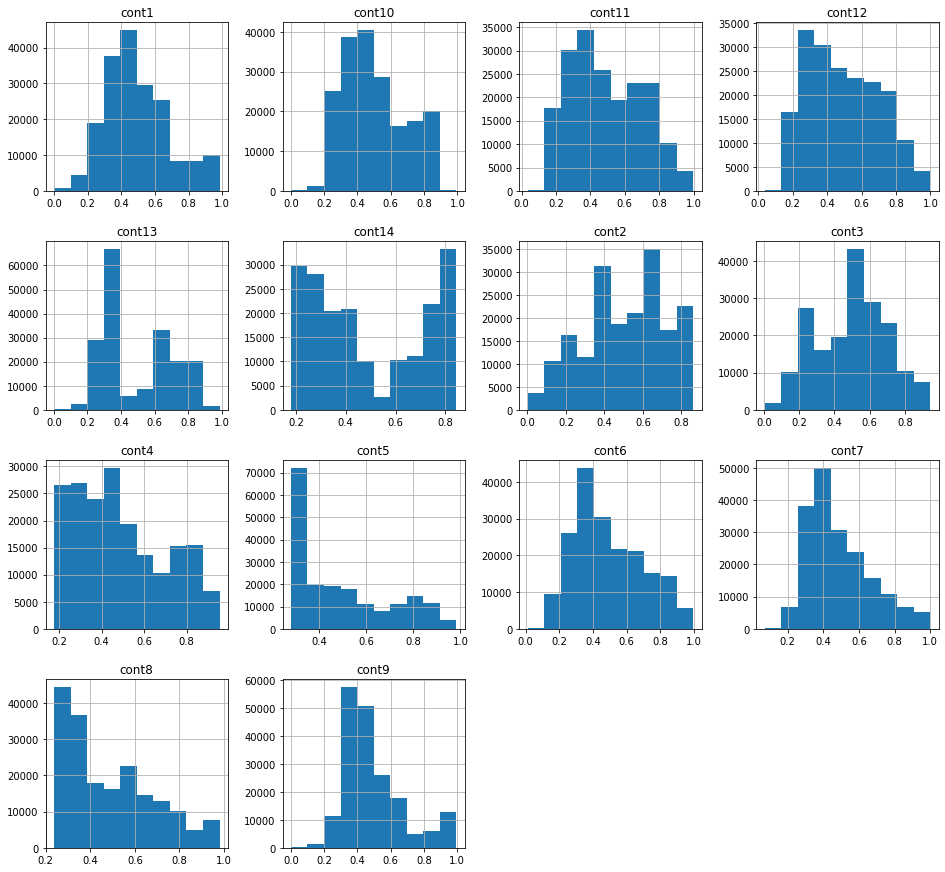

In [23]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

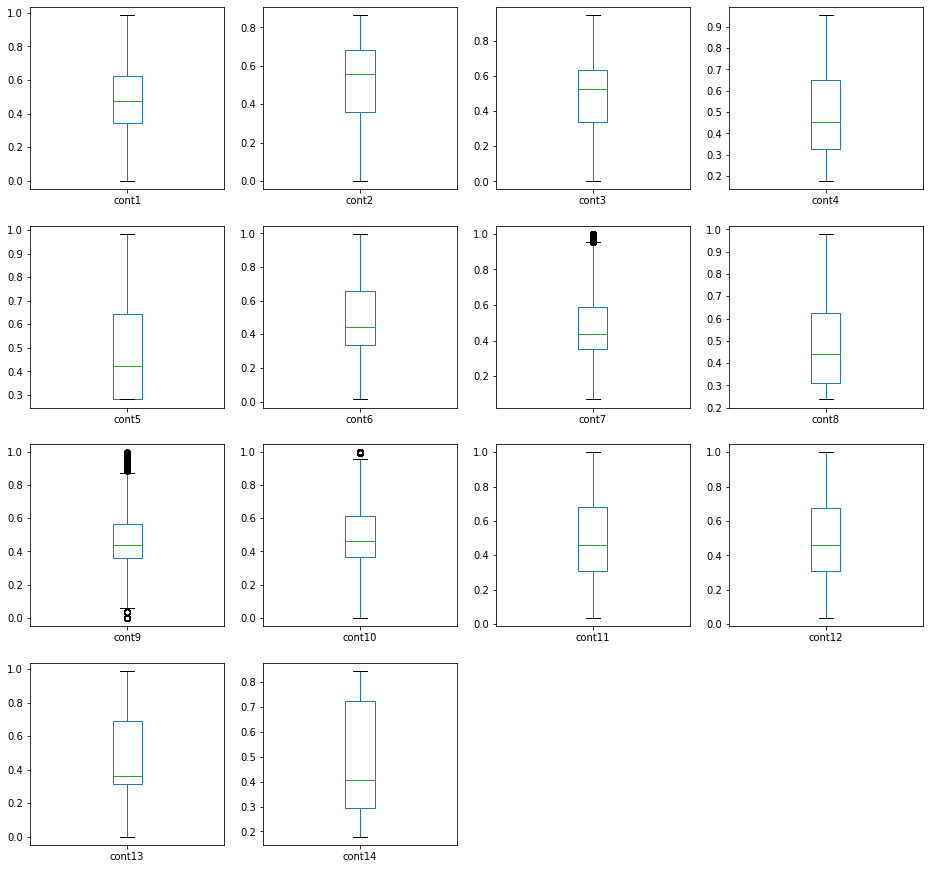

In [24]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

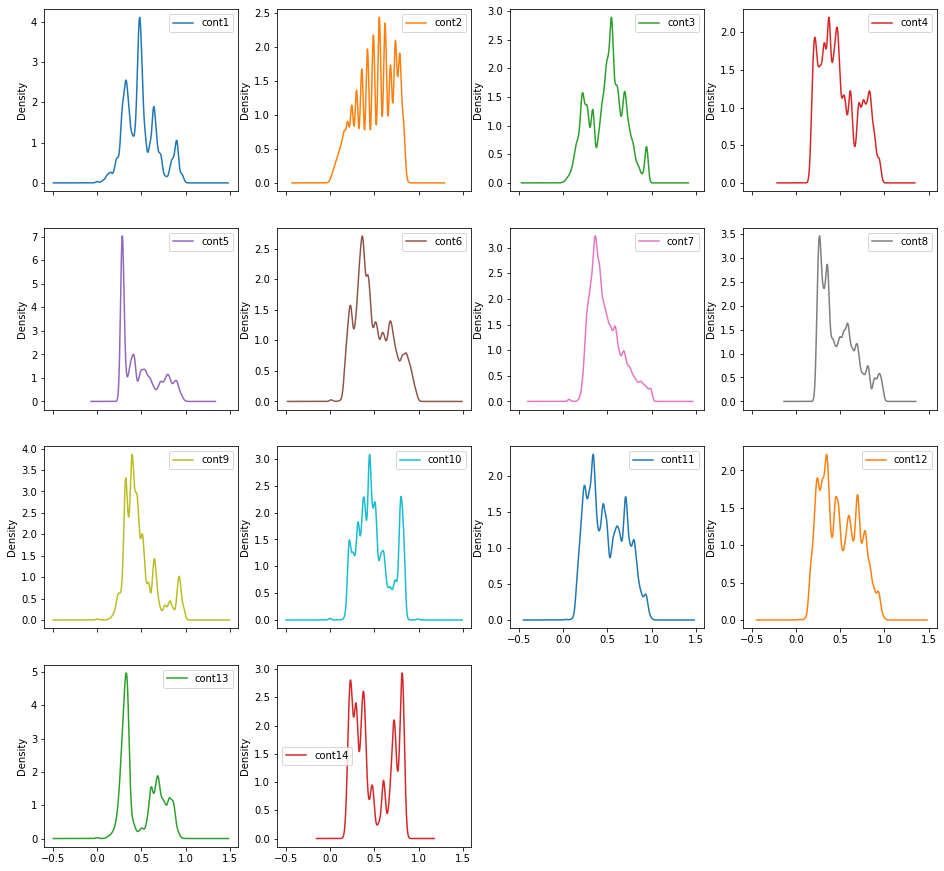

In [25]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

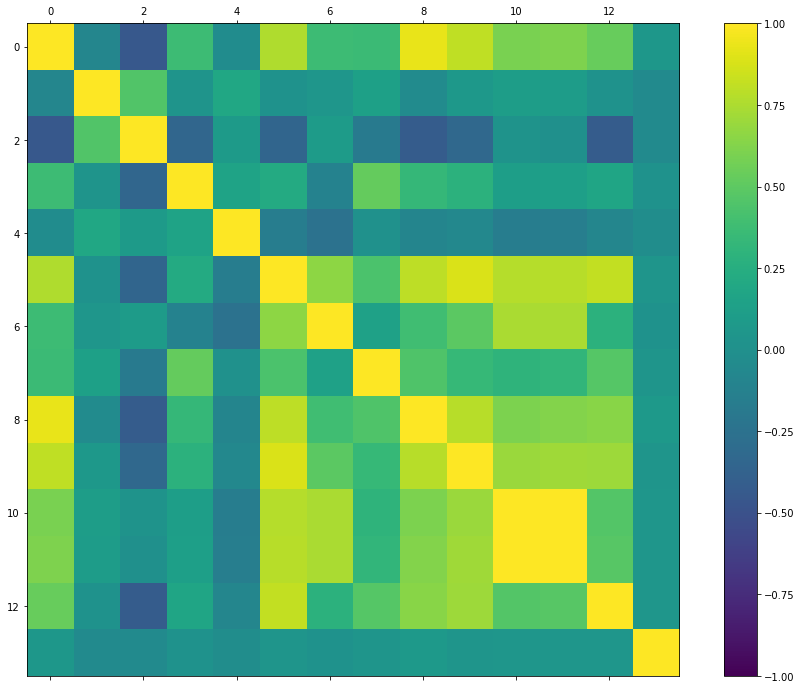

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [0]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [0]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [29]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 1153 entries, cont1 to cat116_Y
dtypes: float64(14), uint8(1139)
memory usage: 224.7 MB
None


In [30]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (141238, 1153) y_train_df.shape: (141238,)
X_test_df.shape: (47080, 1153) y_test_df.shape: (47080,)


### 3.b) Feature Scaling and Data Pre-Processing

In [0]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [0]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (141238, 1153) y_train.shape: (141238,)
X_test.shape: (47080, 1153) y_test.shape: (47080,)


In [0]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate four linear, two non-linear, and four ensemble algorithms:

Linear Algorithms: Linear Regression, Ridge Regression, LASSO Regression, and Elastic Net Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [0]:
# Not applicable for this iteration of the project

### 4.b) Spot-checking baseline algorithms

In [0]:
# Not applicable for this iteration of the project

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning Using the "max_depth" Parameter

In [37]:
# Tuning Algorithm #1 - XGBoost
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm tuning with the max_depth parameter has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
paramGrid1 = dict(max_depth=np.array([3, 6, 9, 12, 15]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best MAE for the Model is:', (grid_result1.best_score_*-1))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm tuning with the max_depth parameter completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -1191.101664 using {'max_depth': 9}
-1253.372453 (5.786375) with: {'max_depth': 3}
-1202.595890 (6.493081) with: {'max_depth': 6}
-1191.101664 (4.979008) with: {'max_depth': 9}
-1199.349571 (6.293806) with: {'max_depth': 12}
-1213.736891 (8.457477) with: {'max_depth': 15}
Best MAE for the Model is: 1191.1016636382258
Model training time: 0:07:49.179096


### 5.b) Algorithm Tuning Using the "min_child_weight" Parameter

In [38]:
# Tuning Algorithm #1 - XGBoost
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm tuning with the min_child_weight parameter has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
paramGrid2 = dict(min_child_weight=np.array([1, 2, 3, 4, 5]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best MAE for the Model is:', (grid_result2.best_score_*-1))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm tuning with the min_child_weight parameter completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -1252.761890 using {'min_child_weight': 3}
-1253.372453 (5.786375) with: {'min_child_weight': 1}
-1252.801646 (5.828571) with: {'min_child_weight': 2}
-1252.761890 (5.740348) with: {'min_child_weight': 3}
-1253.636704 (5.124377) with: {'min_child_weight': 4}
-1253.090038 (5.453663) with: {'min_child_weight': 5}
Best MAE for the Model is: 1252.7618900056586
Model training time: 0:02:27.421567


### 5.c) Algorithm Tuning Using the "learning_rate" Parameter

In [39]:
# Tuning Algorithm #1 - XGBoost
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm tuning with the learning_rate parameter has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model3 = XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
paramGrid3 = dict(learning_rate=np.array([0.1, 0.2, 0.3, 0.4, 0.5]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid3 = GridSearchCV(estimator=tune_model3, param_grid=paramGrid3, scoring=scoring, cv=kfold)
grid_result3 = grid3.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best MAE for the Model is:', (grid_result3.best_score_*-1))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm tuning with the learning_rate parameter completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -1223.530618 using {'learning_rate': 0.3}
-1253.372453 (5.786375) with: {'learning_rate': 0.1}
-1227.433729 (5.186127) with: {'learning_rate': 0.2}
-1223.530618 (3.532556) with: {'learning_rate': 0.3}
-1225.568844 (4.853972) with: {'learning_rate': 0.4}
-1228.877454 (7.156369) with: {'learning_rate': 0.5}
Best MAE for the Model is: 1223.5306178652438
Model training time: 0:02:19.648347


### 5.d) Algorithm Tuning Using the "n_estimators" Parameter

In [40]:
# Tuning Algorithm #1 - XGBoost
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm tuning with the n_estimator parameter has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model4 = XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
paramGrid4 = dict(n_estimators=np.array([1000, 1250, 1500, 1750, 2000]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid4 = GridSearchCV(estimator=tune_model4, param_grid=paramGrid4, scoring=scoring, cv=kfold)
grid_result4 = grid4.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
# tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result4.cv_results_['mean_test_score']
stds = grid_result4.cv_results_['std_test_score']
params = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best MAE for the Model is:', (grid_result4.best_score_*-1))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm tuning the n_estimator parameter completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -1197.339288 using {'n_estimators': 2000}
-1200.678955 (4.992580) with: {'n_estimators': 1000}
-1199.282471 (5.470774) with: {'n_estimators': 1250}
-1198.154489 (5.330781) with: {'n_estimators': 1500}
-1197.702866 (5.255173) with: {'n_estimators': 1750}
-1197.339288 (5.264720) with: {'n_estimators': 2000}
Best MAE for the Model is: 1197.3392882672993
Model training time: 0:11:28.314818


### 5.e) Algorithm Tuning Using Various Parameters

In [41]:
# Tuning Algorithm #1 - XGBoost
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm tuning with all parameters has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model5 = XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
paramGrid5 = dict(max_depth=np.array([3, 6, 9]), min_child_weight=np.array([1, 2, 3]), 
                  learning_rate=np.array([0.1, 0.2, 0.3]), n_estimators=np.array([1000, 1500, 2000]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid5 = GridSearchCV(estimator=tune_model5, param_grid=paramGrid5, scoring=scoring, cv=kfold)
grid_result5 = grid5.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result5.best_score_, grid_result5.best_params_))
means = grid_result5.cv_results_['mean_test_score']
stds = grid_result5.cv_results_['std_test_score']
params = grid_result5.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best MAE for the Model is:', (grid_result5.best_score_*-1))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm tuning with all parameters completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best: -1191.137892 using {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 1000}
-1200.678955 (4.992580) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000}
-1198.154489 (5.330781) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1500}
-1197.339288 (5.264720) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 2000}
-1199.984160 (4.934472) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1000}
-1197.599994 (5.307120) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1500}
-1196.819168 (4.897798) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 2000}
-1200.502637 (5.600752) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 1000}
-1198.281162 (5.930254) with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, '

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [0]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [49]:
test_model1 = XGBRegressor(n_estimators=1000, max_depth=6, learning_rate=0.1, min_child_weight=1,
                           random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', 
                           tree_method='gpu_hist')
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('MAE for the model is: ', mean_absolute_error(y_test, predictions1))
print('R2 for the model is: ', r2_score(y_test, predictions1))
print(test_model1)

MAE for the model is:  1195.102233223608
R2 for the model is:  0.5644892531618824
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)


### 6.b) Create a standalone model using all available data

In [50]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
final_Model = test_model1.fit(X_complete, y_complete)
print(final_Model)

X_complete.shape: (188318, 1153) y_complete.shape: (188318,)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)


### 6.c) Save the final model for later use

In [0]:
# modelName = 'finalModel_Regression.sav'
# dump(finalModel, modelName)

In [0]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 5:33:29.794765
